**Evaluate many models in a sequence**

In [1]:
import warnings

import arviz as az
import pymc3 as pm
import scipy.stats
import theano
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt
%matplotlib inline

%run helpers.ipynb
%run neuralnet.ipynb

In [2]:
# Ignore PyMC3 FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Make plots larger by default
plt.rc("figure", dpi=100)

In [3]:
# Algorithm settings
nuts_kwargs = {
    "draws": 5000,
    "tune": 5000,
    "init": "adapt_diag",
    "target_accept": 0.9,
    "cores": 2,
    "random_seed": [1, 2],
}

advi_kwargs = {
    "n": 20_000,
    "method": "advi",
    "obj_n_mc": 10,
    "obj_optimizer": pm.adagrad(),
}

In [4]:
# Models to build
grid = [
    {
        "algorithm": ["ADVI", "NUTS"],
        "hidden": [1],
        "width": [50],
        "sigma": [0.1, 0.5, 0.75, 1.0, 1.5],
        "noise": [0.5],
    },
    {
        "algorithm": ["ADVI", "NUTS"],
        "hidden": [1],
        "width": [50],
        "sigma": [0.5],
        "noise": [0.1, 0.5, 1.0],
    },
    {
        "algorithm": ["ADVI", "NUTS"],
        "hidden": [1],
        "width": [10],
        "sigma": [1.0, 1.5, 2.0, 3.0],
        "noise": [0.5],
    },
    {
        "algorithm": ["ADVI", "NUTS"],
        "hidden": [1],
        "width": [3],
        "sigma": [1.0, 5.0, 10.0],
        "noise": [0.5],
    },
]
specifications = ParameterGrid(grid)
print(f"Number of configurations: {len(specifications)}")

Number of configurations: 30


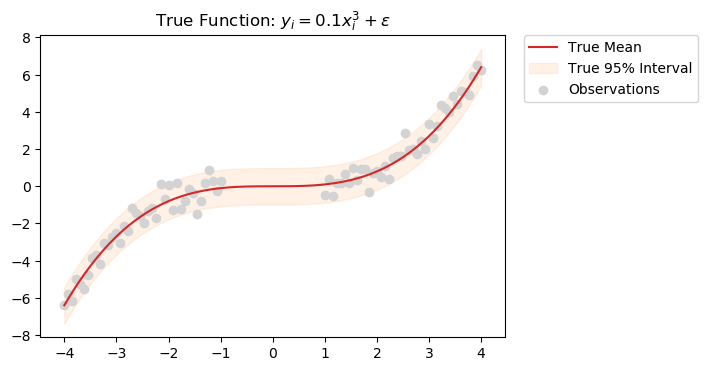

In [5]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.1 * x ** 3, scale=0.5)
func.latex = r"$y_i = 0.1x_i^3 + \varepsilon$"

data_points = [
    {"n_points": 40, "xlim": [-4, -1]},
    {"n_points": 40, "xlim": [1, 4]},
]
df = generate_data(func, points=data_points, seed=4)

# Plot the data
plot_true_function(func, df, title=f"True Function: {func.latex}")

In [6]:
def approximate_posterior_predictive(spec):
    # Fit a neural network with a speficied number of nodes in a single hidden layer
    print("Fitting an MLE model...")
    nn = SimpleNN(
        width=spec["width"], num_iters=5_000, step_size=0.01, checkpoint=1_000, seed=0
    )
    nn.fit(df.x, df.y)
    print("", end="", flush=True)

    x_input = theano.shared(df[["x"]].values)
    y_output = theano.shared(df["y"].values)

    # Build a hierarchical Bayesian neural network. Initialize with MLE.
    model = build_model(
        x_input,
        y_output,
        sigma=spec["sigma"],
        noise=spec["noise"],
        width=spec["width"],
        n_weights=nn.n_weights,
        init=nn.weights,
    )

    # Sample from the posterior
    if spec["algorithm"] == "NUTS":
        trace = pm.sample(**nuts_kwargs, model=model)
    elif spec["algorithm"] == "ADVI":
        mean_field = pm.fit(**advi_kwargs, model=model)
        trace = mean_field.sample(10_000)
    else:
        raise NotImplemented

    return trace, nn

In [ ]:
x_test = np.linspace(df.x.min(), df.x.max(), num=1000)

for i, spec in enumerate(specifications, start=1):
    print(f"Working on model {i} out of {len(specifications)}")

    p = storage_path(**spec)
    save_path = p.with_suffix(p.suffix + ".pickle")
    if save_path.exists():
        print(f"Loading an existing model from {save_path}")
        data = load_model(save_path)
        trace = data["trace"]
        nn = data["nnet"]
    else:
        trace, nn = appxroximate_posterior_predictive(spec)
        print(f"Saving the model to {save_path}")
        save_model(func, df, nn, trace, **spec)

    print("Sampling from the posterior predictive")
    posterior_predictive = simulate_posterior_predictive(
        trace, nn, x_test, n_samples=10_000
    )

    # Run minimal diagnostics
    if spec["algorithm"] in ["NUTS"]:
        tests = az.summary(trace, round_to=2)[["ess_mean", "r_hat"]]
    else:
        tests = None

    print("Plotting and saving the image")
    # Plot the posterior predictive
    algorithm = spec["algorithm"]
    hidden, width = spec["hidden"], spec["width"]
    sigma, noise = spec["sigma"], spec["noise"]
    plot_posterior_predictive(
        x_test,
        posterior_predictive,
        func=func,
        df=df,
        title=f"{algorithm}, Weight Uncertainty {sigma}, Noise {noise},\n"
        f"{width} Nodes in 1 Hidden Layer",
    )
    # Annotate diagnostic info for samplers
    if tests is not None:
        diagnostics = (
            f"Minimum ESS: {tests.ess_mean.min():,.2f}\n"
            f"Max Gelman-Rubin: {tests.r_hat.max():.2f}"
        )
        plt.gcf().text(0.95, 0.15, diagnostics)

    # Save the image
    image_path = p.with_suffix(p.suffix + ".png")
    plt.savefig(image_path, dpi=100, bbox_inches="tight")
    plt.close()

    print()